In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary
import pandas as pd
import gpflow_tools.mean_func as mf
from random import sample
import gpflow_tools.kernels as kern
import validation.metrics as metrics

In [4]:
data = pd.read_excel('Data/full_data_10_08.xlsx')
cols = ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']
for c in data.columns:
    if 'afp' in c or 'bfp' in c or 'mpf' in c or 'efp' in c:
        cols.append(c)

In [5]:
for c in ['Mw', 'Melt_Viscosity']:
    data[c] = np.log10(data[c])

for i in data.index:
    if data.loc[i, 'Shear_Rate'] != 0:
        #data.loc[i,'Shear_Rate'] = np.log10(data.loc[i, 'Shear_Rate'])
        data = data.drop([i])

In [6]:
data

,INDEX,SAMPLE_ID,SMILES,Polymer,Mn,Mw,PDI,PDI (zw),Temperature,Shear_Rate,...,mfp_MQNs38,mfp_MQNs39,mfp_MQNs40,mfp_MQNs41,mfp_MQNs42,mfp_NumAliphaticRings,mfp_NumAromaticRings,mfp_tpsa,Weight 1,Weight 2
0,0,1.0,[*]CC([*])C,poly(prop-1-ene),2600.000000,3.591065,1.50,NaN,200.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN,NaN
1,1,1.0,[*]CC([*])C,poly(prop-1-ene),7834.101382,4.230449,2.17,NaN,200.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN,NaN
2,2,1.0,[*]CC([*])C,poly(prop-1-ene),31981.981982,4.851258,2.22,NaN,200.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN,NaN
3,3,1.0,[*]CC([*])C,poly(prop-1-ene),43829.787234,5.012837,2.35,NaN,200.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN,NaN
4,4,1.0,[*]CC([*])C,poly(prop-1-ene),75757.575758,5.397940,3.30,NaN,200.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,694,NaN,"[*]CC([*])c1ccccc1, [*]CC([*])C#N","polystyrene, polyacrylonitrile",53000.000000,5.025306,NaN,NaN,170.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.047500,NaN,0.76,0.24
695,695,NaN,"[*]CC([*])c1ccccc1, [*]CC([*])C#N","polystyrene, polyacrylonitrile",56000.000000,5.049218,NaN,NaN,170.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.045000,NaN,0.72,0.28
696,696,NaN,"[*]CC([*])c1ccccc1, [*]CC([*])C#N","polystyrene, polyacrylonitrile",56000.000000,5.049218,NaN,NaN,170.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.042500,NaN,0.68,0.32
697,697,NaN,"[*]CC([*])c1ccccc1, [*]CC([*])C#N","polystyrene, polyacrylonitrile",NaN,4.954243,NaN,NaN,170.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.040625,NaN,0.65,0.35


In [7]:
cols.remove('Shear_Rate')
filtered_data = data.loc[:, cols].dropna()
X_tot = np.array(filtered_data.drop(columns=['Melt_Viscosity']))
tot_samples = X_tot.shape[0]
Y_tot = np.array(filtered_data.loc[:,'Melt_Viscosity']).reshape((tot_samples,1))

In [8]:
test_samples = sample(range(tot_samples), round(tot_samples/5))
train_samples = [i for i in range(tot_samples) if i not in test_samples]
X = X_tot[train_samples]
Y = Y_tot[train_samples]
xx = X_tot[test_samples]
yy = Y_tot[test_samples]

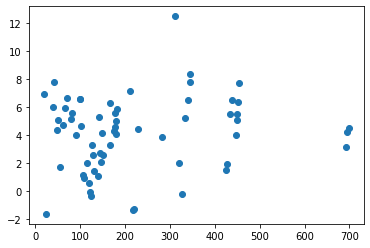

In [9]:
plt.scatter(xx[:,0],yy)
#plt.plot(X, np.power(X,2) + X)

In [14]:
#A = np.concatenate((np.array([3.4]), np.zeros(X_tot.shape[1] - 1))).reshape(-1,1)
#mf = gpflow.mean_functions.Linear(A = A, b = np.zeros((1)))
mean_mol = mf.mol_weight_mean(X_tot.shape[1])
mean_temp = mf.temp_mean()
mean = mf.weight_temp_mean(input_dim = X_tot.shape[1])
k = gpflow.kernels.SquaredExponential()
k_tan =  kern.Tanimoto()

In [15]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function= mean)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))

1.2775019806585042
73.5048952194426


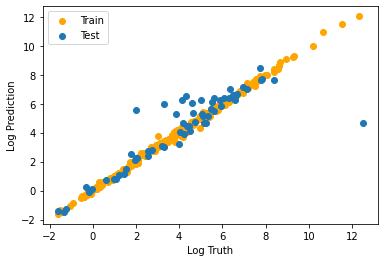

In [16]:
## predict mean and variance of latent GP at test points
mean, var = m.predict_y(xx)
## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

# # plot
# plt.figure(figsize=(12, 6))
# #plt.plot(X[:,0], Y, "kx", mew=2)
# plt.plot(xx, mean, "C0", lw=2)
# plt.fill_between(
#     xx[:, 0],
#     mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
#     mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
#     color="C0",
#     alpha=0.2,
# )

# plt.plot(xx[:,0], samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
mean_train, var_train = m.predict_y(X)
plt.scatter(Y, mean_train, c = 'orange')
plt.scatter(yy, mean)
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Train','Test'])
rmse = metrics.RMSE(mean, yy)
mape = metrics.MAPE(mean, yy)
print(rmse)
print(mape)

0.8182853529958639


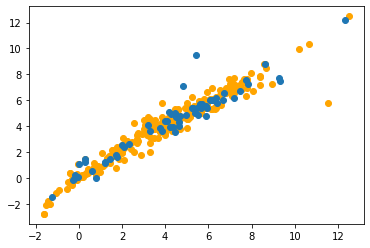

In [213]:
## predict mean and variance of latent GP at test points
mean, var = m.predict_y(xx)
## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

# # plot
# plt.figure(figsize=(12, 6))
# #plt.plot(X[:,0], Y, "kx", mew=2)
# plt.plot(xx, mean, "C0", lw=2)
# plt.fill_between(
#     xx[:, 0],
#     mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
#     mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
#     color="C0",
#     alpha=0.2,
# )

# plt.plot(xx[:,0], samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
mean_train, var_train = m.predict_y(X)
plt.scatter(Y, mean_train, c = 'orange')
plt.scatter(yy, mean)
rmse = np.sqrt(np.sum(np.power((yy-mean),2)/len(yy)))
print(rmse)

In [13]:
l = np.ones((3,5))

In [15]:
l[:, 0:]

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

In [64]:
metrics.MAPE(mean, yy)

0.41405276150541603